# Data preparation

In [1]:
#install two things below if it's needed on your system 
#conda install -c cyclus java-jdk 
#pip install pyspark

In [2]:
from pyspark import SparkContext
sc = SparkContext("local", "First App")

In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('insurance').getOrCreate()
df = spark.read.csv('train.csv',inferSchema=True,header=True)
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Driving_License: integer (nullable = true)
 |-- Region_Code: double (nullable = true)
 |-- Previously_Insured: integer (nullable = true)
 |-- Vehicle_Age: string (nullable = true)
 |-- Vehicle_Damage: string (nullable = true)
 |-- Annual_Premium: double (nullable = true)
 |-- Policy_Sales_Channel: double (nullable = true)
 |-- Vintage: integer (nullable = true)
 |-- Response: integer (nullable = true)



In [4]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

###Correct schema of some variables

In [5]:
from pyspark.sql.types import StructField,StringType,IntegerType,DoubleType,StructType
df_schema = StructType([
    StructField('id', StringType(), True),
    StructField('Gender', StringType(), True),
    StructField('Age', IntegerType(), True),
    StructField('Driving_License', StringType(), True),
    StructField('Region_Code', StringType(), True),
    StructField('Previously_Insured', StringType(), True),
    StructField('Vehicle_Age', StringType(), True),
    StructField('Vehicle_Damage', StringType(), True),
    StructField('Annual_Premium', DoubleType(), True),
    StructField('Policy_Sales_Channel', StringType(), True),
    StructField('Vintage', IntegerType(), True),
    StructField('Response', IntegerType(), True)
    ])
df = spark.createDataFrame(df.collect(),schema = df_schema)
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Driving_License: string (nullable = true)
 |-- Region_Code: string (nullable = true)
 |-- Previously_Insured: string (nullable = true)
 |-- Vehicle_Age: string (nullable = true)
 |-- Vehicle_Damage: string (nullable = true)
 |-- Annual_Premium: double (nullable = true)
 |-- Policy_Sales_Channel: string (nullable = true)
 |-- Vintage: integer (nullable = true)
 |-- Response: integer (nullable = true)



In [6]:
df.count()

381109

In [7]:
df.show()

+---+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+--------+
| id|Gender|Age|Driving_License|Region_Code|Previously_Insured|Vehicle_Age|Vehicle_Damage|Annual_Premium|Policy_Sales_Channel|Vintage|Response|
+---+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+--------+
|  1|  Male| 44|              1|       28.0|                 0|  > 2 Years|           Yes|       40454.0|                26.0|    217|       1|
|  2|  Male| 76|              1|        3.0|                 0|   1-2 Year|            No|       33536.0|                26.0|    183|       0|
|  3|  Male| 47|              1|       28.0|                 0|  > 2 Years|           Yes|       38294.0|                26.0|     27|       1|
|  4|  Male| 21|              1|       11.0|                 1|   < 1 Year|            No|       28619.0|               152.0|    203|  

# now let's check nulls for each column 
### For nulls(missing values), we can impute them by statistical values or drop it if it had too much

In [8]:
from pyspark.sql.functions import*
from pyspark.sql.functions import when,count,col
null_report=df.select([count(when(isnull(c), c)).alias(c) for c in df.columns])
print("Number of Rows: ",df.count(), "   Number of Columns: ",len(df.columns))
null_report.show()

Number of Rows:  381109    Number of Columns:  12
+---+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+--------+
| id|Gender|Age|Driving_License|Region_Code|Previously_Insured|Vehicle_Age|Vehicle_Damage|Annual_Premium|Policy_Sales_Channel|Vintage|Response|
+---+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+--------+
|  0|     0|  0|              0|          0|                 0|          0|             0|             0|                   0|      0|       0|
+---+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+--------+



### Surprisingly, the data has no nulls, so we can do some descriptive analysis

In [9]:
df.show()

+---+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+--------+
| id|Gender|Age|Driving_License|Region_Code|Previously_Insured|Vehicle_Age|Vehicle_Damage|Annual_Premium|Policy_Sales_Channel|Vintage|Response|
+---+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+--------+
|  1|  Male| 44|              1|       28.0|                 0|  > 2 Years|           Yes|       40454.0|                26.0|    217|       1|
|  2|  Male| 76|              1|        3.0|                 0|   1-2 Year|            No|       33536.0|                26.0|    183|       0|
|  3|  Male| 47|              1|       28.0|                 0|  > 2 Years|           Yes|       38294.0|                26.0|     27|       1|
|  4|  Male| 21|              1|       11.0|                 1|   < 1 Year|            No|       28619.0|               152.0|    203|  

In [10]:
# Here numercal columns are picked for descriptive analysis 
df.select('Annual_Premium','Vintage','Age').describe().show()

+-------+------------------+------------------+------------------+
|summary|    Annual_Premium|           Vintage|               Age|
+-------+------------------+------------------+------------------+
|  count|            381109|            381109|            381109|
|   mean|30564.389581458323|154.34739667654136|38.822583565331705|
| stddev|17213.155056979947| 83.67130362658658| 15.51161101809548|
|    min|            2630.0|                10|                20|
|    max|          540165.0|               299|                85|
+-------+------------------+------------------+------------------+



### From the descriptive statistic, there is no issue. Now, let us remove outliers.

In [11]:
import matplotlib.pyplot as plt 
import pandas as pd
import random as rnd 

Text(0.5, 1.0, 'Vintage box-plot')

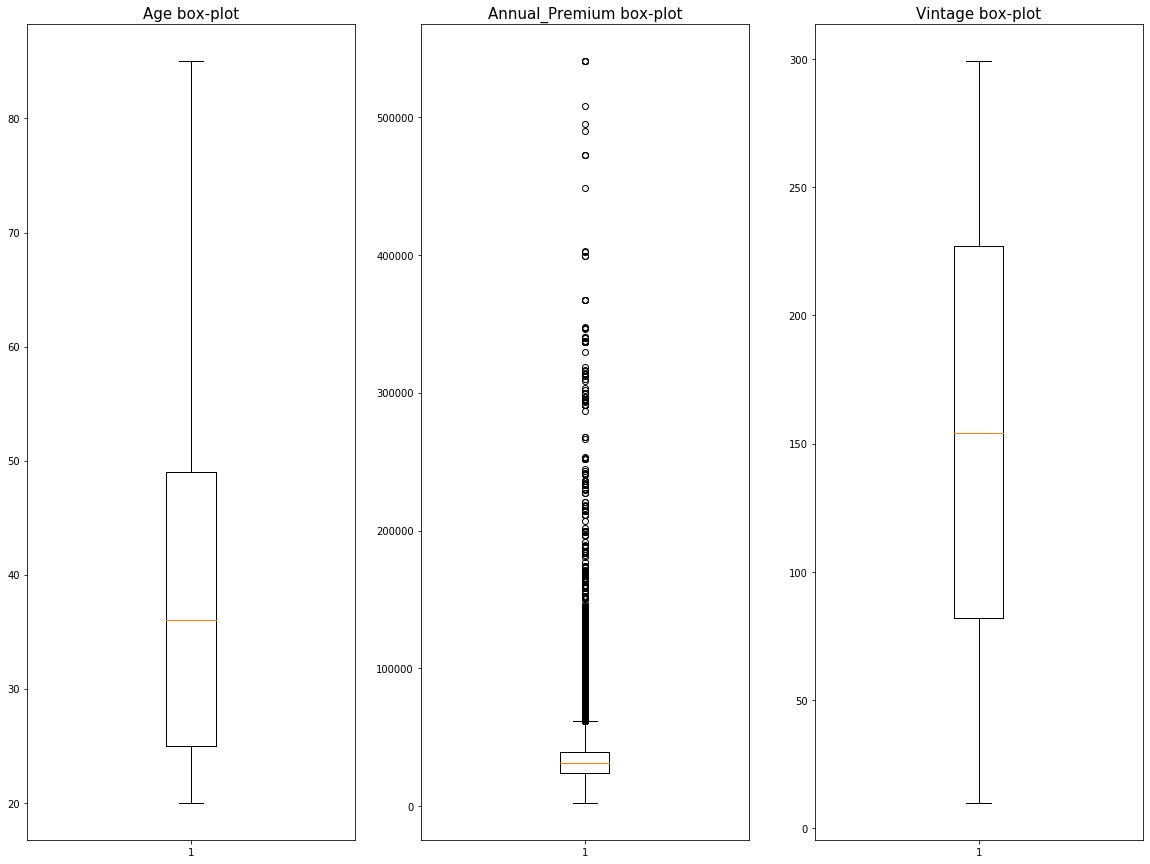

In [12]:
df1=df.toPandas()
f,(ax1, ax2, ax3) = plt.subplots(1,3, sharey=False,figsize=(20,15)) 
ax1.boxplot(df1['Age'])
ax1.set_title("Age box-plot", fontsize=15)
ax2.boxplot(df1['Annual_Premium'])
ax2.set_title("Annual_Premium box-plot", fontsize=15)
ax3.boxplot(df1['Vintage'])
ax3.set_title("Vintage box-plot", fontsize=15)

### According to the box-plots, there are some outliers in 'Annual_Premium'

### Next, we use the interquantile rule to delete outliers.

In [13]:
quantiles = {
    c: dict(
        zip(["q1", "q3"], df.approxQuantile(c, [0.25, 0.75], 0))
    )
    for c in ["Age", "Annual_Premium","Vintage"]
}
quantiles

{'Age': {'q1': 25.0, 'q3': 49.0},
 'Annual_Premium': {'q1': 24405.0, 'q3': 39400.0},
 'Vintage': {'q1': 82.0, 'q3': 227.0}}

In [14]:
for i in quantiles:
    iqr = quantiles[i]['q3'] - quantiles[i]['q1']
    quantiles[i]['lower_bound'] = quantiles[i]['q1'] - (iqr * 1.5)
    quantiles[i]['upper_bound'] = quantiles[i]['q3'] + (iqr * 1.5)
print(quantiles)

{'Age': {'q1': 25.0, 'q3': 49.0, 'lower_bound': -11.0, 'upper_bound': 85.0}, 'Annual_Premium': {'q1': 24405.0, 'q3': 39400.0, 'lower_bound': 1912.5, 'upper_bound': 61892.5}, 'Vintage': {'q1': 82.0, 'q3': 227.0, 'lower_bound': -135.5, 'upper_bound': 444.5}}


In [15]:
import pyspark.sql.functions as f
df_clean=df.select(
    "*",
    *[
        f.when(
            f.col(c).between(quantiles[c]['lower_bound'], quantiles[c]['upper_bound']),
            0
        ).otherwise(1).alias(c+"_out") 
        for c in ["Age", "Annual_Premium","Vintage"]
    ]
)
df_clean.show(10)

+---+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+--------+-------+------------------+-----------+
| id|Gender|Age|Driving_License|Region_Code|Previously_Insured|Vehicle_Age|Vehicle_Damage|Annual_Premium|Policy_Sales_Channel|Vintage|Response|Age_out|Annual_Premium_out|Vintage_out|
+---+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+--------+-------+------------------+-----------+
|  1|  Male| 44|              1|       28.0|                 0|  > 2 Years|           Yes|       40454.0|                26.0|    217|       1|      0|                 0|          0|
|  2|  Male| 76|              1|        3.0|                 0|   1-2 Year|            No|       33536.0|                26.0|    183|       0|      0|                 0|          0|
|  3|  Male| 47|              1|       28.0|                 0|  > 2 Years|          

In [16]:
from pyspark.sql.functions import col
df_clean=df_clean.withColumn("outliers", col("Age_out")+col("Annual_Premium_out")+col("Vintage_out"))
df_clean.show()

+---+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+--------+-------+------------------+-----------+--------+
| id|Gender|Age|Driving_License|Region_Code|Previously_Insured|Vehicle_Age|Vehicle_Damage|Annual_Premium|Policy_Sales_Channel|Vintage|Response|Age_out|Annual_Premium_out|Vintage_out|outliers|
+---+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+--------+-------+------------------+-----------+--------+
|  1|  Male| 44|              1|       28.0|                 0|  > 2 Years|           Yes|       40454.0|                26.0|    217|       1|      0|                 0|          0|       0|
|  2|  Male| 76|              1|        3.0|                 0|   1-2 Year|            No|       33536.0|                26.0|    183|       0|      0|                 0|          0|       0|
|  3|  Male| 47|              1|       2

In [17]:
#removing outliers to make a better dataset
df_clean = df_clean.filter((df_clean.outliers==0))
df_new = df_clean.select(['id','Gender','Age','Driving_License','Region_Code','Previously_Insured','Vehicle_Age','Vehicle_Damage','Annual_Premium','Policy_Sales_Channel','Vintage','Response'])
df_new.select('Age','Annual_Premium','Vintage').describe().show()

+-------+------------------+------------------+------------------+
|summary|               Age|    Annual_Premium|           Vintage|
+-------+------------------+------------------+------------------+
|  count|            370789|            370789|            370789|
|   mean| 38.67034351072982|29264.643972717637|154.34544174719315|
| stddev|15.440166283175861|14743.056656364903| 83.67047843171595|
|    min|                20|            2630.0|                10|
|    max|                85|           61892.0|               299|
+-------+------------------+------------------+------------------+



###Let check how many percentage of data we have left.

In [18]:
df_new.count()/df.count()*100

97.29211327992779

### After deleting outliers, we still have about 97% of the data left. Therefore, it is enough to use in the next steps.

# Data visualization

In [19]:
import matplotlib.pyplot as plt 
import pandas as pd
import random as rnd 
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark import SparkContext

In [20]:
df_rs=df_new.select('Response').toPandas()
df_rs.shape

(370789, 1)

###  Response (Target variable)

In [21]:
# Create function for pie-chart
def draw_pie_chart(data, column, fig, renamed_index_dict, title):
    default_colors = ['#66b3ff', '#ff9999', '#99ff99', '#ffcc99', '#c2c2f0', '#ffb3e6', '#ff6666']
    rnd.shuffle(default_colors)
    ax = data[column].value_counts().rename(index = renamed_index_dict).plot.pie(colors = default_colors, autopct='%1.1f%%', startangle=180, title = title)
    ax.set_ylabel('')  
    
#66b3ff = blue
#ff9999 = light red
#99ff99 = green
#ffcc99 = orange
#c2c2f0 = purple
#ffb3e6 = pink
#ff6666 = red

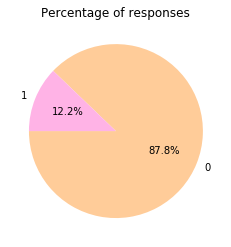

In [22]:
fig = plt.gcf()
draw_pie_chart(df_rs, 'Response', fig, {0: 0, 1: 1}, 'Percentage of responses')

#### The data is unbalanced. Therefore, we have to resampling before building a prediction model.

In [23]:
df_pd=df_new.toPandas()
df_rs_no = df_pd[df_pd.Response == 0]
df_rs_yes = df_pd[df_pd.Response == 1]

#### Gender , Driving_License , Previously_Insured , Vehicle_Age , and Vehicle_Damage

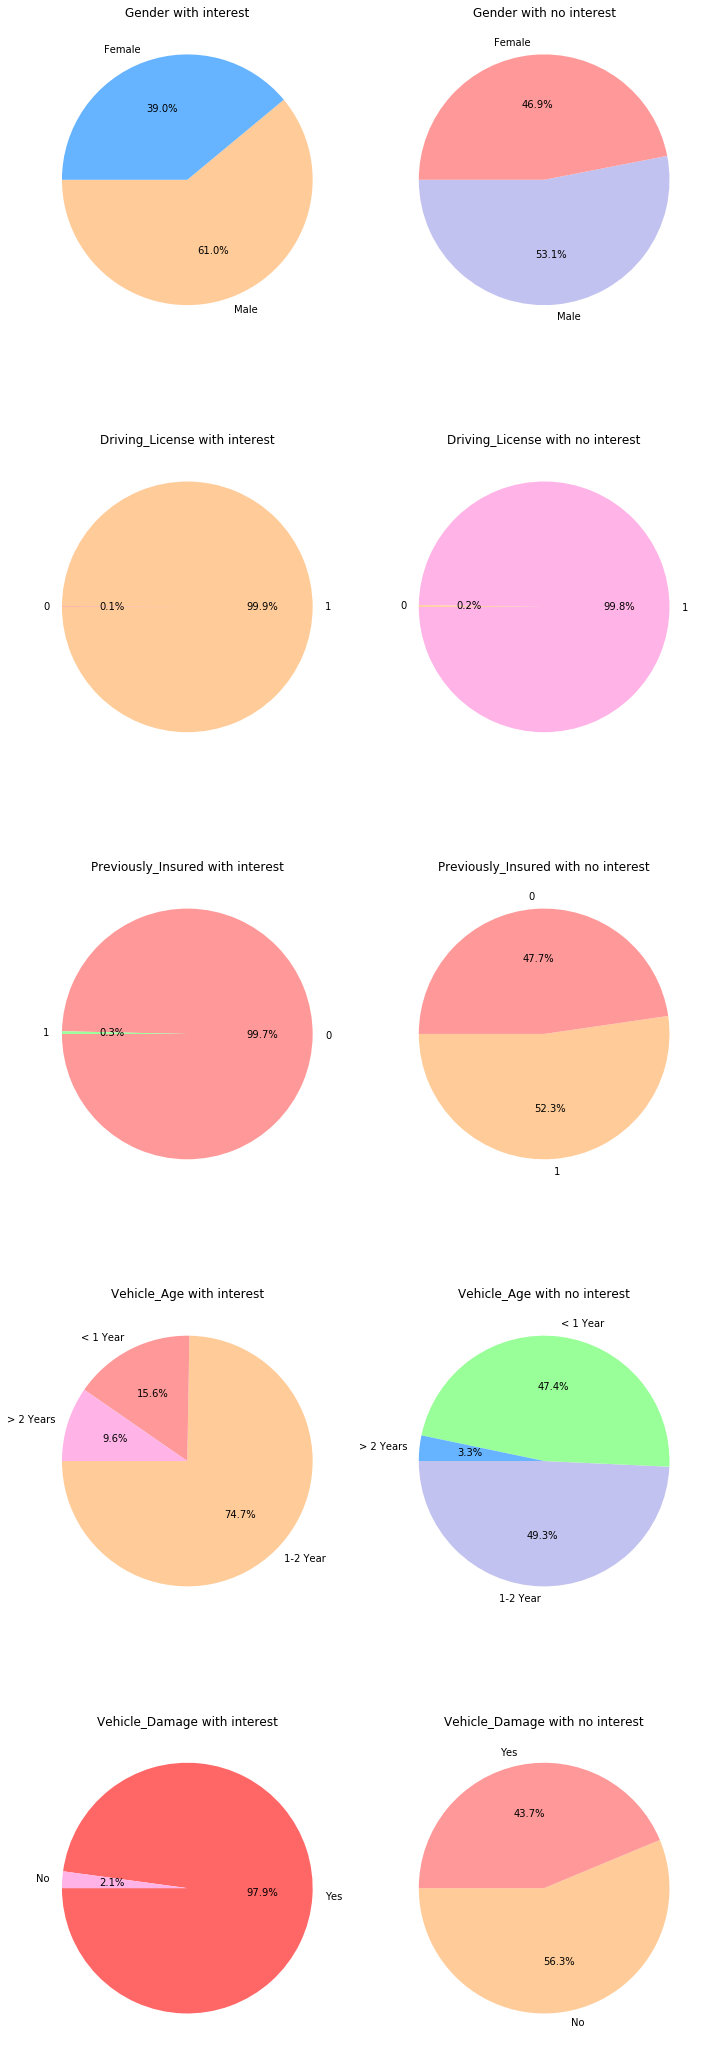

In [24]:
fig = plt.gcf()
fig.set_size_inches(10, 30)
grid_rows = 5
grid_cols = 2

# Draw Gender Pie chart
plt.subplot(grid_rows, grid_cols, 1)
draw_pie_chart(df_rs_yes, 'Gender', fig, {0: 'Female', 1: 'Male'}, 'Gender with interest')

plt.subplot(grid_rows, grid_cols, 2)
draw_pie_chart(df_rs_no , 'Gender', fig, {0: 'Female', 1: 'Male'}, 'Gender with no interest')

# Draw Driving_License chart
plt.subplot(grid_rows, grid_cols, 3)
draw_pie_chart(df_rs_yes, 'Driving_License', fig, {0:'0', 1:'1'}, 'Driving_License with interest')

plt.subplot(grid_rows, grid_cols, 4)
draw_pie_chart(df_rs_no, 'Driving_License', fig, {0:'0', 1:'1'}, 'Driving_License with no interest')

# Draw Previously_Insured chart
plt.subplot(grid_rows, grid_cols, 5)
draw_pie_chart(df_rs_yes, 'Previously_Insured', fig, {0:'0', 1:'1'}, 'Previously_Insured with interest')

plt.subplot(grid_rows, grid_cols, 6)
draw_pie_chart(df_rs_no , 'Previously_Insured', fig, {0:'0', 1:'1'}, 'Previously_Insured with no interest')

# Draw Vehicle_Age status chart
plt.subplot(grid_rows, grid_cols, 7)
draw_pie_chart(df_rs_yes, 'Vehicle_Age', fig, {0:'< 1 Year', 1:'1-2 Year',2:'> 2 Years'}, 'Vehicle_Age with interest')

plt.subplot(grid_rows, grid_cols, 8)
draw_pie_chart(df_rs_no , 'Vehicle_Age', fig, {0:'< 1 Year', 1:'1-2 Year',2:'> 2 Years'}, 'Vehicle_Age with no interest')

# Draw Vehicle_Damage type chart
plt.subplot(grid_rows, grid_cols, 9)
draw_pie_chart(df_rs_yes, 'Vehicle_Damage', fig, {0:'Yes', 1:'No'}, 'Vehicle_Damage with interest')

plt.subplot(grid_rows, grid_cols, 10)
draw_pie_chart(df_rs_no , 'Vehicle_Damage', fig, {0:'Yes', 1:'No'}, 'Vehicle_Damage with no interest')


fig.tight_layout()
plt.show()

###  Age , Annual_Premium , and Vintage

Text(0.5, 1.0, 'Vintage vs Response')

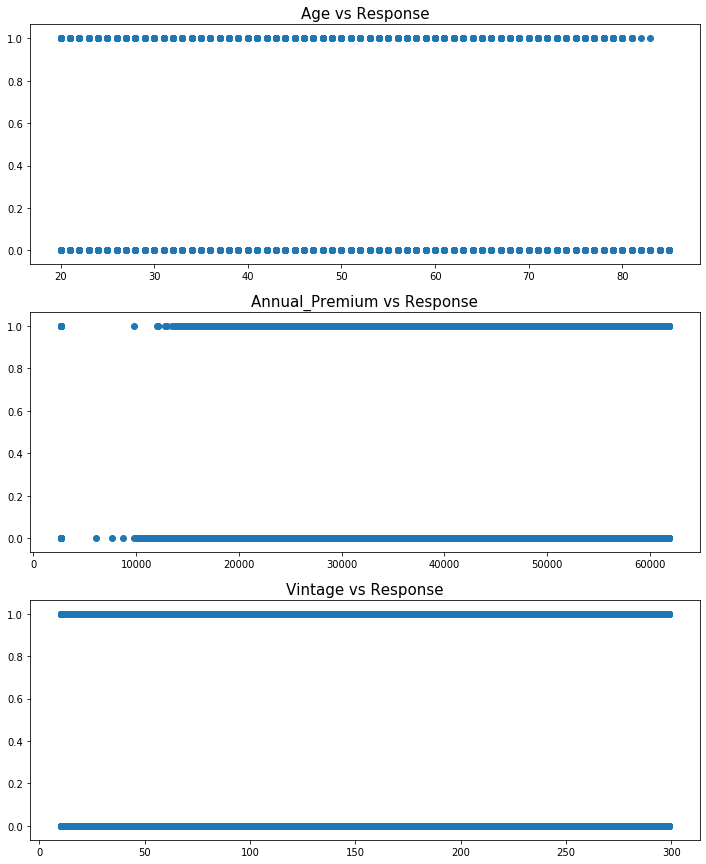

In [25]:
f,(ax1, ax2, ax3) = plt.subplots(3,1, sharey=True,figsize=(12,15)) 
ax1.scatter(df_pd['Age'],df_pd['Response'])
ax1.set_title("Age vs Response", fontsize=15)
ax2.scatter(df_pd['Annual_Premium'],df_pd['Response'])
ax2.set_title("Annual_Premium vs Response", fontsize=15)
ax3.scatter(df_pd['Vintage'],df_pd['Response'])
ax3.set_title("Vintage vs Response", fontsize=15)

In [26]:
#split data to train and test 
train_vi,test_vi = df_new.randomSplit([0.8,0.2],500)

# Resamlping for unbalaneced data

#### Oversampling

In [27]:
#oversampling is implemented 
from pyspark.sql.functions import col, explode, array, lit
major_df = train_vi.filter(col("Response") == 0)
minor_df = train_vi.filter(col("Response") == 1)
ratio = int(major_df.count()/minor_df.count())
print("ratio: {}".format(ratio))
a = range(ratio)
oversampled_df = minor_df.withColumn("dummy", explode(array([lit(x) for x in a ]))).drop('dummy')
train_vi_os = major_df.unionAll(oversampled_df)
train_vi_os.show()

ratio: 7
+------+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+--------+
|    id|Gender|Age|Driving_License|Region_Code|Previously_Insured|Vehicle_Age|Vehicle_Damage|Annual_Premium|Policy_Sales_Channel|Vintage|Response|
+------+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+--------+
|    10|Female| 32|              1|        6.0|                 1|   < 1 Year|            No|       28771.0|               152.0|     80|       0|
|   100|Female| 24|              1|        7.0|                 1|   < 1 Year|           Yes|        2630.0|               160.0|     68|       0|
|  1000|Female| 21|              1|       46.0|                 1|   < 1 Year|            No|       29298.0|               160.0|     37|       0|
| 10000|Female| 25|              1|       45.0|                 1|   < 1 Year|            No|       18843.0| 

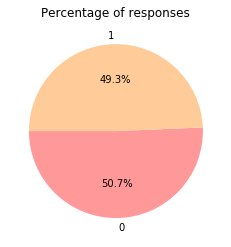

In [28]:
#Now let's check whether the data is balanced then we'll enter model building part.
df_rs1=train_vi_os.select('Response').toPandas()
fig = plt.gcf()
draw_pie_chart(df_rs1, 'Response', fig, {0: 0, 1: 1}, 'Percentage of responses')

### The data is balanced now, next is model budilding for prediction!

# Machine Learning Model Building

### Label encoding

In [29]:
from pyspark.ml.feature import (VectorAssembler,VectorIndexer,
                                StringIndexer,OneHotEncoder)

In [30]:
VA_indexer = StringIndexer(inputCol='Vehicle_Age',outputCol='Vehicle_AgeIndex')
VD_indexer = StringIndexer(inputCol='Vehicle_Damage',outputCol='Vehicle_DamageIndex')
Gen_indexer = StringIndexer(inputCol='Gender',outputCol='GenderIndex')
DL_indexer = StringIndexer(inputCol='Driving_License',outputCol='Driving_LicenseIndex')
RC_indexer = StringIndexer(inputCol='Region_Code',outputCol='Region_CodeIndex')
PSC_indexer = StringIndexer(inputCol='Policy_Sales_Channel',outputCol='Policy_Sales_ChannelIndex')
PI_indexer = StringIndexer(inputCol='Previously_Insured',outputCol='Previously_InsuredIndex')

In [31]:
train_vi_os.show(5)

+------+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+--------+
|    id|Gender|Age|Driving_License|Region_Code|Previously_Insured|Vehicle_Age|Vehicle_Damage|Annual_Premium|Policy_Sales_Channel|Vintage|Response|
+------+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+--------+
|    10|Female| 32|              1|        6.0|                 1|   < 1 Year|            No|       28771.0|               152.0|     80|       0|
|   100|Female| 24|              1|        7.0|                 1|   < 1 Year|           Yes|        2630.0|               160.0|     68|       0|
|  1000|Female| 21|              1|       46.0|                 1|   < 1 Year|            No|       29298.0|               160.0|     37|       0|
| 10000|Female| 25|              1|       45.0|                 1|   < 1 Year|            No|       18843.0|          

In [32]:
input_cols_Label= ['GenderIndex', 'Vehicle_AgeIndex', 'Vehicle_DamageIndex', 'Age', 'Driving_LicenseIndex', 'Region_CodeIndex', 'Previously_InsuredIndex','Annual_Premium','Policy_Sales_ChannelIndex','Vintage']
assembler_Label = VectorAssembler(inputCols=input_cols_Label,outputCol='features')

In [33]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import DecisionTreeClassifier
#pipeline 
from pyspark.ml import Pipeline

In [34]:
# split data to  train and test
#train_vi,test_vi = df_new1.randomSplit([0.8,0.2],500)

## Feature selection by Random forest classifier

In [35]:
rf_vi = RandomForestClassifier(featuresCol='features',labelCol='Response',maxBins=200)
pipeline_rf_Label = Pipeline(stages=[VA_indexer,VD_indexer,Gen_indexer,RC_indexer,DL_indexer,PSC_indexer,PI_indexer,assembler_Label,rf_vi])

In [36]:
fit_rf_Label = pipeline_rf_Label.fit(train_vi_os)

In [37]:
fit_rf_Label.stages[-1].featureImportances

SparseVector(10, {0: 0.0002, 1: 0.0178, 2: 0.5627, 3: 0.0789, 4: 0.0003, 5: 0.008, 6: 0.3027, 7: 0.0002, 8: 0.0291, 9: 0.0})

In [38]:
df_new2 = fit_rf_Label.transform(train_vi_os)

In [39]:
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

In [40]:
ExtractFeatureImp(fit_rf_Label.stages[-1].featureImportances, df_new2, "features")

,idx,name,vals,score
5,2,Vehicle_DamageIndex,"[Yes, No]",0.562667
8,6,Previously_InsuredIndex,"[0, 1]",0.302687
0,3,Age,NaN,0.078914
9,8,Policy_Sales_ChannelIndex,"[26.0, 152.0, 124.0, 156.0, 160.0, 122.0, 157....",0.029137
4,1,Vehicle_AgeIndex,"[1-2 Year, < 1 Year, > 2 Years]",0.017808
7,5,Region_CodeIndex,"[28.0, 8.0, 46.0, 41.0, 15.0, 29.0, 30.0, 3.0,...",0.007972
6,4,Driving_LicenseIndex,"[1, 0]",0.000307
1,7,Annual_Premium,NaN,0.000247
3,0,GenderIndex,"[Male, Female]",0.000246
2,9,Vintage,NaN,0.000015


In [41]:
features=ExtractFeatureImp(fit_rf_Label.stages[-1].featureImportances, df_new2, "features")
features=features[features.score>0.05].iloc[:,1].tolist()
vars=features+['Response']
vars

['Vehicle_DamageIndex', 'Previously_InsuredIndex', 'Age', 'Response']

In [42]:
train_vi_os_selected = fit_rf_Label.transform(train_vi_os).select(vars)
test_vi_selected = fit_rf_Label.transform(test_vi).select(vars)
train_vi_selected = fit_rf_Label.transform(train_vi).select(vars)  #  train dataset before oversampling

In [43]:
assembler = VectorAssembler(inputCols= features, outputCol="features")
df_train_os = assembler.transform(train_vi_os_selected)
df_test = assembler.transform(test_vi_selected)
df_train = assembler.transform(train_vi_selected) #  train dataset before oversampling

## Using 3 algorithms to build the model.
### 1. Logistic Regression
### 2. Random Forest Classifier
### 3. Decision Tree Classifier

In [44]:
lr_vi = LogisticRegression(featuresCol='features',labelCol='Response')
rf_vi = RandomForestClassifier(featuresCol='features',labelCol='Response',maxBins=200)
dt_vi = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'Response')

In [45]:
fit_lr = lr_vi.fit(df_train_os)
fit_rf = rf_vi.fit(df_train_os)
fit_dt = dt_vi.fit(df_train_os)

In [46]:
test_lr_results = fit_lr.transform(df_test)
test_rf_results = fit_rf.transform(df_test)
test_dt_results = fit_dt.transform(df_test)

In [47]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics

In [48]:
AUC_eval = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='Response')
Accu_evaluator = MulticlassClassificationEvaluator()
Accu_evaluator.setPredictionCol('prediction')
Accu_evaluator.setLabelCol('Response')

MulticlassClassificationEvaluator_197a2ef7e64c

### Accuracy

In [49]:
Accu_test_lr = Accu_evaluator.evaluate(test_lr_results, {Accu_evaluator.metricName: "accuracy"})
Accu_test_rf = Accu_evaluator.evaluate(test_rf_results, {Accu_evaluator.metricName: "accuracy"})
Accu_test_dt = Accu_evaluator.evaluate(test_dt_results, {Accu_evaluator.metricName: "accuracy"})

print("Test Accuracy of Logistic Regression:  ", Accu_test_lr)
print("Test Accuracy of Random Forest Classifier:  ", Accu_test_rf)
print("Test Accuracy of Decision Tree Classifier:  ", Accu_test_dt)

Test Accuracy of Logistic Regression:   0.6383528298059369
Test Accuracy of Random Forest Classifier:   0.6600175806342552
Test Accuracy of Decision Tree Classifier:   0.6862668199337345


### AUC

In [50]:
AUC_test_lr = AUC_eval.evaluate(test_lr_results)
AUC_test_rf = AUC_eval.evaluate(test_rf_results)
AUC_test_dt = AUC_eval.evaluate(test_dt_results)

print("AUC of Logistic Regression: ", AUC_test_lr)
print("AUC of Random Forest Classifier: ", AUC_test_rf)
print("AUC of Decision Tree Classifier: ", AUC_test_dt)

AUC of Logistic Regression:  0.7839513178259239
AUC of Random Forest Classifier:  0.7900153915562177
AUC of Decision Tree Classifier:  0.7914649163336103


#Sensitivity

In [51]:
rdd_dt= sc.parallelize(test_dt_results.select('prediction','Response').collect())
rdd_lr= sc.parallelize(test_lr_results.select('prediction','Response').collect())
rdd_rf= sc.parallelize(test_rf_results.select('prediction','Response').collect())

In [52]:
df_dt= sqlContext.createDataFrame(rdd_dt, ["prediction", "Response"])
df_lr= sqlContext.createDataFrame(rdd_lr, ["prediction", "Response"])
df_rf= sqlContext.createDataFrame(rdd_rf, ["prediction", "Response"])

### Check evaluation standards

### Evaluation standard

In [53]:
tp_dt = df_dt[(df_dt.Response == 1) & (df_dt.prediction == 1)].count()
tn_dt = df_dt[(df_dt.Response == 0) & (df_dt.prediction == 0)].count()
fp_dt = df_dt[(df_dt.Response == 0) & (df_dt.prediction == 1)].count()
fn_dt = df_dt[(df_dt.Response == 1) & (df_dt.prediction == 0)].count()


tp_lr = df_lr[(df_lr.Response == 1) & (df_lr.prediction == 1)].count()
tn_lr = df_lr[(df_lr.Response == 0) & (df_lr.prediction == 0)].count()
fp_lr = df_lr[(df_lr.Response == 0) & (df_lr.prediction == 1)].count()
fn_lr = df_lr[(df_lr.Response == 1) & (df_lr.prediction == 0)].count()

tp_rf = df_rf[(df_rf.Response == 1) & (df_rf.prediction == 1)].count()
tn_rf = df_rf[(df_rf.Response == 0) & (df_rf.prediction == 0)].count()
fp_rf = df_rf[(df_rf.Response == 0) & (df_rf.prediction == 1)].count()
fn_rf = df_rf[(df_rf.Response == 1) & (df_rf.prediction == 0)].count()


## Sensitivity

In [54]:
Sensitivity_df =float(tp_dt)/(tp_dt + fn_dt)
print("Sensitivity for  decision tree",Sensitivity_df)

print('\n')

Sensitivity_lr =float(tp_lr)/(tp_lr + fn_lr)
print("Sensitivity for  logistic regression",Sensitivity_lr)

Sensitivity_rf =float(tp_rf)/(tp_rf + fn_rf)
print("Sensitivity for random forest ",Sensitivity_rf)

Sensitivity for  decision tree 0.9300393037619314


Sensitivity for  logistic regression 0.975743964065132
Sensitivity for random forest  0.961257720381808


### The best model is Decision Tree Classifier with 68.93% accuracy and 92.91% sensitivity.

### Checking overfitting. Compare accuray of train (before oversampling) and test dataset

In [55]:
train_dt_results = fit_dt.transform(df_train)
Accu_train_dt = Accu_evaluator.evaluate(train_dt_results, {Accu_evaluator.metricName: "accuracy"})

print("Test Accuracy of Decision Tree Classifier:  ", Accu_test_dt)
print("Train Accuracy of Decision Tree Classifier:  ", Accu_train_dt)

Test Accuracy of Decision Tree Classifier:   0.6862668199337345
Train Accuracy of Decision Tree Classifier:   0.687297031437388


### Both accuray scores are about the same. The model is not overfitting.

# Improving the model with 2 approaches.
### 1. Change Label encoding to one-hot encoding
### 2. Change oversampling to undersampling

### 1. Change Label encoding to one-hot encoding

In [56]:
train_vi_os = train_vi_os.select('Vehicle_Damage', 'Age', 'Previously_Insured','Response')
test_vi =  test_vi.select('Vehicle_Damage', 'Age', 'Previously_Insured','Response')
# based on feature selection

In [57]:
VD_indexer = StringIndexer(inputCol='Vehicle_Damage',outputCol='Vehicle_DamageIndex')
PI_indexer = StringIndexer(inputCol='Previously_Insured',outputCol='Previously_InsuredIndex')

VD_encoder = OneHotEncoder(inputCol='Vehicle_DamageIndex',outputCol='Vehicle_DamageVec')
PI_encoder =OneHotEncoder(inputCol='Previously_InsuredIndex',outputCol='Previously_InsuredVec')

In [58]:
input_cols_hot= ['Vehicle_DamageVec', 'Age', 'Previously_InsuredVec']
assembler_hot = VectorAssembler(inputCols=input_cols_hot,outputCol='features')

In [59]:
dt_vi = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'Response')
pipeline_dt_hot = Pipeline(stages=[VD_indexer,PI_indexer,VD_encoder,PI_encoder,assembler_hot,dt_vi])

In [60]:
fit_dt_hot = pipeline_dt_hot.fit(train_vi_os)
test_dt_hot_results = fit_dt_hot.transform(test_vi)
Accu_test_hot = Accu_evaluator.evaluate(test_dt_hot_results, {Accu_evaluator.metricName: "accuracy"})
print("Test Accuracy of Decision Tree Classifier for One-hot encoding:  ", Accu_test_hot)

Test Accuracy of Decision Tree Classifier for One-hot encoding:   0.6862668199337345


### There is no difference between Label encoding and One-hot encoding

### 2.Change oversampling to undersampling

In [61]:
from pyspark.sql.functions import col, explode, array, lit
major_df = train_vi.filter(col("Response") == 0)
minor_df = train_vi.filter(col("Response") == 1)
ratio = int(major_df.count()/minor_df.count())
print("ratio: {}".format(ratio))
sampled_majority_df = major_df.sample(False, 1/ratio)
train_vi_us = sampled_majority_df.unionAll(minor_df)
train_vi_us =  train_vi_us.select('Vehicle_Damage', 'Age', 'Previously_Insured','Response')

ratio: 7


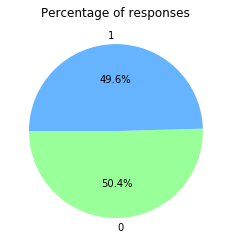

In [62]:
df_rs2=train_vi_us.select('Response').toPandas()
fig = plt.gcf()
draw_pie_chart(df_rs2, 'Response', fig, {0: 0, 1: 1}, 'Percentage of responses')

In [63]:
input_cols_us= ['Vehicle_DamageIndex', 'Age', 'Previously_InsuredIndex']
assembler_us = VectorAssembler(inputCols=input_cols_us,outputCol='features')

In [64]:
dt_vi = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'Response')
pipeline_dt_us = Pipeline(stages=[VD_indexer,PI_indexer,assembler_us,dt_vi])

In [65]:
fit_dt_us = pipeline_dt_us.fit(train_vi_us)
test_dt_us_results = fit_dt_us.transform(test_vi)
Accu_test_us = Accu_evaluator.evaluate(test_dt_us_results, {Accu_evaluator.metricName: "accuracy"})
print("Test Accuracy of Decision Tree Classifier for undersampling:  ", Accu_test_us)

Test Accuracy of Decision Tree Classifier for undersampling:   0.6600175806342552


### The accuracy score of undersampling slightly decreases.
### Therefore, we summarize that the best model is built from,
### 1. Using 3 variables, including Vehicle_Damage, Age, Previously_Insured.
### 2. Using Oversampling to solve unbalanced issue.
### 3. Label encoding and One-hot encoding both generate same result.
### 4. Using Decision Tree Classifier algorithm.
### 5. Accuracy score = 68.93% and AUC = 0.79.
### 6. Sensitivity score = 92.91%